In [1]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas as pd
import xarray
import h5py
import healpy as hp
import time

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting
from ulmo.analysis import spatial_plots as sp

# Load tables

In [2]:
os.getenv('ENDPOINT_URL') 
llc_uniform= ulmo_io.load_main_table( 's3://llc/Tables/test_uniform_r0.5_test.feather' )
llc_uniform.head()

Read main table: s3://llc/Tables/test_uniform_r0.5_test.feather


,lat,lon,row,col,datetime,LLC_file,pp_file,pp_root,field_size,mean_temperature,...,T10,pp_idx,pp_type,LL,U_mean,V_mean,U_rms,V_rms,UV_mean,UV_rms
0,71.725098,-177.172684,12895,10607,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-1.467546,...,-1.541000,647491,0,648.981934,-0.099179,-0.001986,0.059771,0.063255,0.141285,0.082805
1,71.747978,-175.380554,12895,10676,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,-0.492408,...,-1.540001,384768,0,-513.771851,-0.008606,-0.042140,0.041484,0.108360,0.046431,0.037870
2,71.758400,-173.559555,12895,10746,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,3.271719,...,2.540999,283882,0,345.448669,0.070156,-0.045817,0.022577,0.044823,0.099820,0.029986
3,71.755905,-171.737854,12895,10816,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,2.945127,...,2.229000,613023,0,169.709839,0.081717,-0.010355,0.024675,0.039160,0.115622,0.034708
4,71.740822,-169.943695,12895,10885,2011-09-30,s3://llc/ThetaUVSalt/LLC4320_2011-09-30T00_00_...,s3://llc/PreProc/LLC_uniform_test_preproc.h5,llc_std,64,2.364319,...,1.891000,537161,0,349.981262,0.039346,0.019852,0.023803,0.031211,0.057416,0.030541


# Work on functions

In [3]:
eval_tbl = llc_uniform
nside = 64

In [4]:
# Grab lats, lons
lats = eval_tbl.lat.values
lons = eval_tbl.lon.values

# Grab LL values
vals = eval_tbl.LL.values

# Healpix coords
theta = (90 - lats) * np.pi / 180.  # convert into radians
phi = lons * np.pi / 180.
idx_all = hp.pixelfunc.ang2pix(nside, theta, phi) # returns the healpix pixel numbers that correspond to theta and phi values

# Count events
npix_hp = hp.nside2npix(nside)  # returns the number of pixels on map, based on nside parameter

### Look at idx_all

In [5]:
idx_all.shape[0] == eval_tbl.shape[0]

True

In [6]:
idx_series_RD = pd.Series(idx_all)
idx_series_RD

0          1250
1          1251
2          1251
3          1252
4          1252
          ...  
781657    48642
781658    48577
781659    48664
781660    48600
781661    48665
Length: 781662, dtype: int64

In [7]:
idx_series = idx_series_RD.sort_values()
idx_series

130290     1200
390843     1200
130289     1200
651397     1200
651398     1200
          ...  
260543    48665
130276    48665
130266    48665
651384    48665
781661    48665
Length: 781662, dtype: int64

In [8]:
pixels = pd.unique(idx_series)

### Create a subroutine: for a unique pixel, gather all LL values and then take the median

In [9]:
pixel = pixels[0]

In [49]:
import time

In [50]:
meds = np.ma.masked_array(np.zeros(npix_hp, dtype='float'))
 
start = time.time()

# find where which cutouts to put in that pixel
where = np.where(pixel == idx_series)
first = where[0][0]
last = where[0][-1]
indices = idx_series[first:last + 1].index

# evaluate the median LL value for that pixel 
vals = eval_tbl.iloc[indices.to_numpy()].LL.to_numpy()

meds[pixel] = np.median( vals )
end = time.time()   

In [51]:
end -start

0.0033833980560302734

#### Should take about 3 minutes for all

### Iterate this subroutine for all pixels

In [52]:
pixels = pd.unique(pd.Series(idx_all).sort_values())
meds = np.ma.masked_array(np.zeros(npix_hp, dtype='float'))

for pixel in pixels: 
    
    # find where which cutouts to put in that pixel
    where = np.where(pixel == idx_series)
    first = where[0][0]
    last = where[0][-1]
    indices = idx_series[first:last + 1].index
    
    # evaluate the median LL value for that pixel 
    vals = eval_tbl.iloc[indices.to_numpy()].LL.to_numpy()
    
    meds[pixel] = np.median( vals )
    

In [48]:
pixels.shape

(32973,)

### Incorporate into the function

In [53]:
def evals_to_healpix_meds(eval_tbl, nside,  mask=True):
    """
    Generate a healpix map of where the input
    MHW Systems are located on the globe

    Parameters
    ----------
    mhw_sys : pandas.DataFrame
    nside : int  # nside is a number that sets the resolution of map
    mask : bool, optional

    Returns
    -------
    num of events, lats, lons, median values : hp.ma, np.ndarray, np.ndarray, hp.ma

    """
    # Grab lats, lons
    lats = eval_tbl.lat.values
    lons = eval_tbl.lon.values

    # Grab LL values
    vals = eval_tbl.LL.values

    # Healpix coords
    theta = (90 - lats) * np.pi / 180.  # convert into radians
    phi = lons * np.pi / 180.
    idx_all = hp.pixelfunc.ang2pix(nside, theta, phi) # returns the healpix pixel numbers that correspond to theta and phi values

    # Intialize the arrays
    npix_hp = hp.nside2npix(nside)  # returns the number of pixels on map, based on nside parameter
    all_events = np.ma.masked_array(np.zeros(npix_hp, dtype='int')) # array of all pixels on map
    med_values = np.ma.masked_array(np.zeros(npix_hp, dtype='float')) # will contain median LL value in that pixel

    # Count events
    for i, idx in enumerate(idx_all):
        all_events[idx] += 1 # pixels concentrated with data pts >= 1 ; those without data remain 0

    zero = all_events == 0 
    float_events = all_events.astype(float)
# ~ operator is called the complement bitwise operator 
# inverts the True/False values
# [~zero] selects pixels where the cutouts are (where events = 1 exist)


    # Calculate median values
    
    pixels = pd.unique(pd.Series(idx_all).sort_values())

    for pixel in pixels: 
    
        # find where which cutouts to put in that pixel
        where = np.where(pixel == idx_series)
        first = where[0][0]
        last = where[0][-1]
        indices = idx_series[first:last + 1].index
    
        # evaluate the median LL value for that pixel 
        vals = eval_tbl.iloc[indices.to_numpy()].LL.to_numpy()
    
        med_values[pixel] = np.median( vals )


    # Mask
    evts = hp.ma(float_events)
    meds = hp.ma(med_values)
    if mask:  # if you want to mask float_events
        evts.mask = zero # current mask set to zero array, where Trues (no events) are masked
        meds.mask = zero 

    # Angles
    hp_lons, hp_lats = hp.pixelfunc.pix2ang(nside, np.arange(npix_hp), lonlat=True)

    # Return
    return evts, hp_lons, hp_lats, meds

In [57]:
def show_med_LL(main_tbl:pd.DataFrame, 
                 nside=64, 
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='viridis', show=True):
    """Generate a global map of the location of the input
    cutouts
    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True
    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events, hp_lons, hp_lats, hp_values = evals_to_healpix_meds(
        main_tbl, nside, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()

    tformM = ccrs.Mollweide()
    tformP = ccrs.PlateCarree()

    ax = plt.axes(projection=tformM)

    if tricontour:
        cm = plt.get_cmap(color)
        img = ax.tricontourf(hp_lons, hp_lats, hp_values, transform=tformM,
                         levels=20, cmap=cm)#, zorder=10)
    else:
        cm = plt.get_cmap(color)
        # Cut
        good = np.invert(hp_values.mask)
        img = plt.scatter(x=hp_lons[good],
            y=hp_lats[good],
            c=hp_values[good], vmin = -1000, vmax = 500, 
            cmap=cm,
            s=1,
            transform=tformP)

    # Colorbar
    cb = plt.colorbar(img, orientation='horizontal', pad=0.)
    if lbl is not None:
        clbl = 'mean_LL'
        cb.set_label(clbl, fontsize=20.)
    cb.ax.tick_params(labelsize=17)

    # Coast lines
    if not tricontour:
        ax.coastlines(zorder=10)
        ax.set_global()
    
        gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
            color='black', alpha=0.5, linestyle=':', draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right=False
        gl.xlines = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'black'}# 'weight': 'bold'}
        gl.ylabel_style = {'color': 'black'}# 'weight': 'bold'}
        #gl.xlocator = mticker.FixedLocator([-180., -160, -140, -120, -60, -20.])
        #gl.xlocator = mticker.FixedLocator([-240., -180., -120, -65, -60, -55, 0, 60, 120.])
        #gl.ylocator = mticker.FixedLocator([0., 15., 30., 45, 60.])


    # Layout and save
    if show:
        plt.show()

    return ax

/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


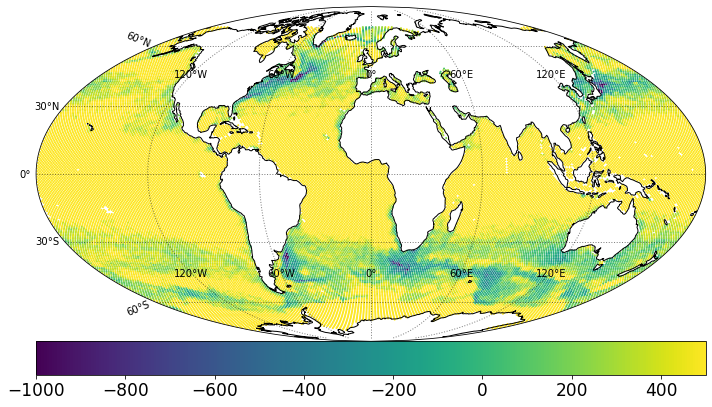

<GeoAxesSubplot:>

In [58]:
show_med_LL( llc_uniform) 